In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from matplotlib.colors import ListedColormap
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_random_state


In [2]:
from dataset import generated, existing, SplitDataset

# Generated data

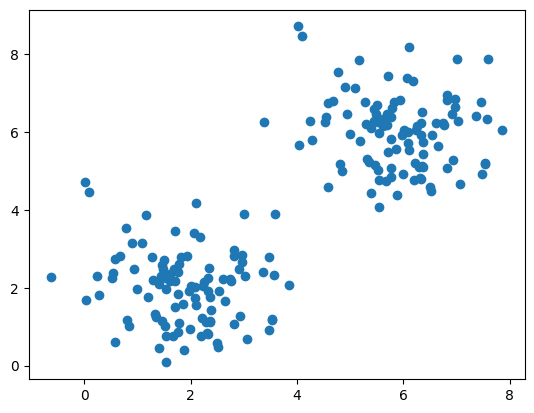

In [3]:
X, Y = generated(100)
plt.scatter(X[:, 0], X[:, 1])

# Split Dataset 

In [4]:
X_labeled, X_unlabeled, Y_labeled = SplitDataset(X, Y, test_size=0.85)


In [5]:
def normalize_to_2pi(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return 2 * np.pi * (data - min_val) / (max_val - min_val)

X_labeled_normalized = normalize_to_2pi(X_labeled)
X_unlabeled_normalized = normalize_to_2pi(X_unlabeled)
X_normalize = normalize_to_2pi(X)



In [6]:
from Qkernel import QKernel

# Cost Function

For a dataset with feature vectors $\{x_i\}$ and associated labels $\{y_i\}$, the target alignment of the kernel function $k$ is given by:

$$
\text{TA}(k) = \frac{
    \sum_{i,j=1}^n y_i y_j k(x_i, x_j)
}{
    \sqrt{\sum_{i,j=1}^n y_i y_j} \cdot \sqrt{\sum_{i,j=1}^n k(x_i, x_j)^2}
}
$$

Basically it evaluates how well a **kernel function** $k(x_i, x_j)$ aligns with the **target labels** $y_i$ of a dataset. It quantifies the similarity between:  

- The **kernel matrix** (entries $k(x_i, x_j)$), and  
- The **ideal target matrix** (entries $y_i y_j$).  

In [7]:
def get_cost_func(X, Y, cost_func_params, qkernel, n_clusters=None):
    """
    Constructs the cost function for training the quantum kernel using target alignment.
    """
    return lambda params: -qml.kernels.target_alignment(
        X, Y,
        kernel=lambda x1, x2: qkernel.kernel_circuit(x1, x2, params)[0],
        **cost_func_params
    )

In [8]:
def train_kernel(X, Y, data, qkernel, cost_func_params={},
                 n_clusters=None, steps=100, lr=0.01, verbose=True):
    """
    Trains the variational quantum kernel by minimizing the negative alignment.
    Stores kernel matrices at every 10 steps in a dictionary.
    """
    params = qkernel.params.copy()
    cost_fn = get_cost_func(X, Y, cost_func_params, qkernel, n_clusters)
    
    opt = qml.AdamOptimizer(lr)
    loss_history = []
    kernel_matrices = {}  # Dictionary to store kernel matrices


    for step in range(steps):
        params, loss = opt.step_and_cost(cost_fn, params)
        loss_history.append(loss)

        if verbose and step % 10 == 0:
            print(f"Step {step:3d} | Loss: {loss:.6f}")
            
            # Compute and store kernel matrix every 10 steps
            trained_kernel = lambda x1, x2: qkernel.kernel_circuit(x1, x2, params)[0]
            K = qml.kernels.square_kernel_matrix(data, trained_kernel)
            kernel_matrices[step] = K  

    return params, loss_history, kernel_matrices

In [9]:
from Ansatz import Ansatz2, Ansatz

In [10]:
from sklearn.manifold import MDS

def plot_kernel(kernel_mat, y_test, ax):
    """Plot kernel matrix on a specific subplot axis"""
    embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    dissimilarities = 1 - kernel_mat
    X_transformed = embedding.fit_transform(dissimilarities)
    
    sc = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=y_test, cmap='viridis')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    return sc

/Users/skande/Intership/.venv/lib/python3.11/site-packages/pennylane_qiskit/qiskit_device_legacy.py:132: UserWarning: The analytic calculation of expectations, variances and probabilities is only supported on statevector backends, not on the aer_simulator. Such statistics obtained from this device are estimates based on samples.
  warnings.warn(self.analytic_warning_message.format(backend), UserWarning)


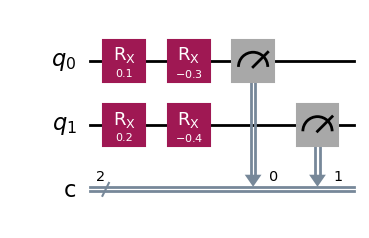

In [8]:
# Define the ansatz
def ansatz(x, wires):
    qml.templates.embeddings.AngleEmbedding(features=x, wires=wires, rotation="X")

# Get the adjoint
adjoint_ansatz = qml.adjoint(ansatz)

# Use the Qiskit Aer device
dev = qml.device("qiskit.aer", wires=2, shots=None)
wires = dev.wires.tolist()

# Define the QNode
@qml.qnode(dev)
def kernel_circuit(x1, x2):
    ansatz(x1, wires=wires)
    adjoint_ansatz(x2, wires=wires)
    return qml.probs(wires=wires)

# Sample inputs
x1 = [0.1, 0.2]
x2 = [0.3, 0.4]

# Evaluate the circuit at least once
_ = kernel_circuit(x1, x2)

def kernel(x1, x2):
    return kernel_circuit(x1, x2)[0]

dev._circuit.draw(output='mpl')

In [12]:
init_kernel = lambda x1, x2: kernel(x1, x2)

Converged at iteration 2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


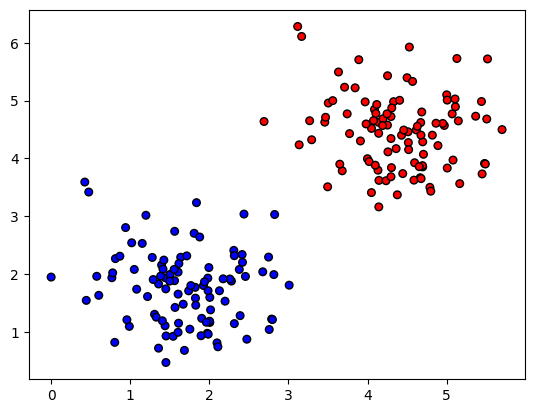

In [88]:
km = KernelKMeans(n_clusters=2, max_iter=100, random_state=0, verbose=1, kernel=init_kernel)
    
result = km.fit(X_normalize).labels_
print(result)

cmap = ListedColormap(['#FF0000', '#0000FF'])  # Red for cluster 1, Blue for cluster 2

plt.scatter(X_normalize[:, 0], X_normalize[:, 1], c=result, cmap=cmap, s=30, edgecolor='k')

In [11]:
# 1. Instantiate QKernel 
qkernel = QKernel(
    num_wires=2,
    ansatz = Ansatz,
    num_layers=2,                
    device_name="qiskit.aer",  
    shots=None                    
)

/Users/skande/Intership/.venv/lib/python3.11/site-packages/pennylane_qiskit/qiskit_device_legacy.py:132: UserWarning: The analytic calculation of expectations, variances and probabilities is only supported on statevector backends, not on the aer_simulator. Such statistics obtained from this device are estimates based on samples.
  warnings.warn(self.analytic_warning_message.format(backend), UserWarning)


In [62]:
# 1. Instantiate QKernel 
qkernel = QKernel(
    num_wires=2,
    ansatz = Ansatz,
    num_layers=6,                
    device_name="default.qubit",  
    shots=None                    
)

# 2. Train the kernel
t_params, loss, kernel_X = train_kernel(
    X=X_labeled_normalized,
    Y=Y_labeled,
    data = X_normalize,
    qkernel=qkernel,
    steps=20,
    lr=0.01,
    verbose=True
)

Step   0 | Loss: -0.421893
Step  10 | Loss: -0.472136


In [16]:
print(X[0])
print(X[1])

[2.49671415 0.58462926]
[1.8617357  1.57935468]


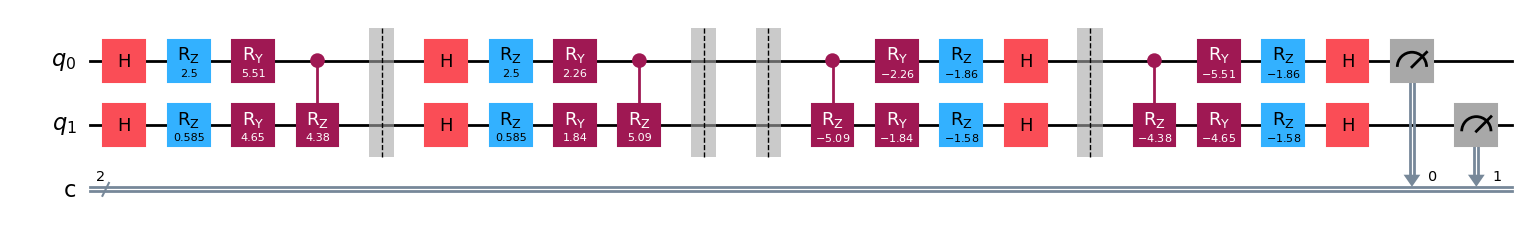

In [12]:
qkernel.visualize(X[0], X[1])

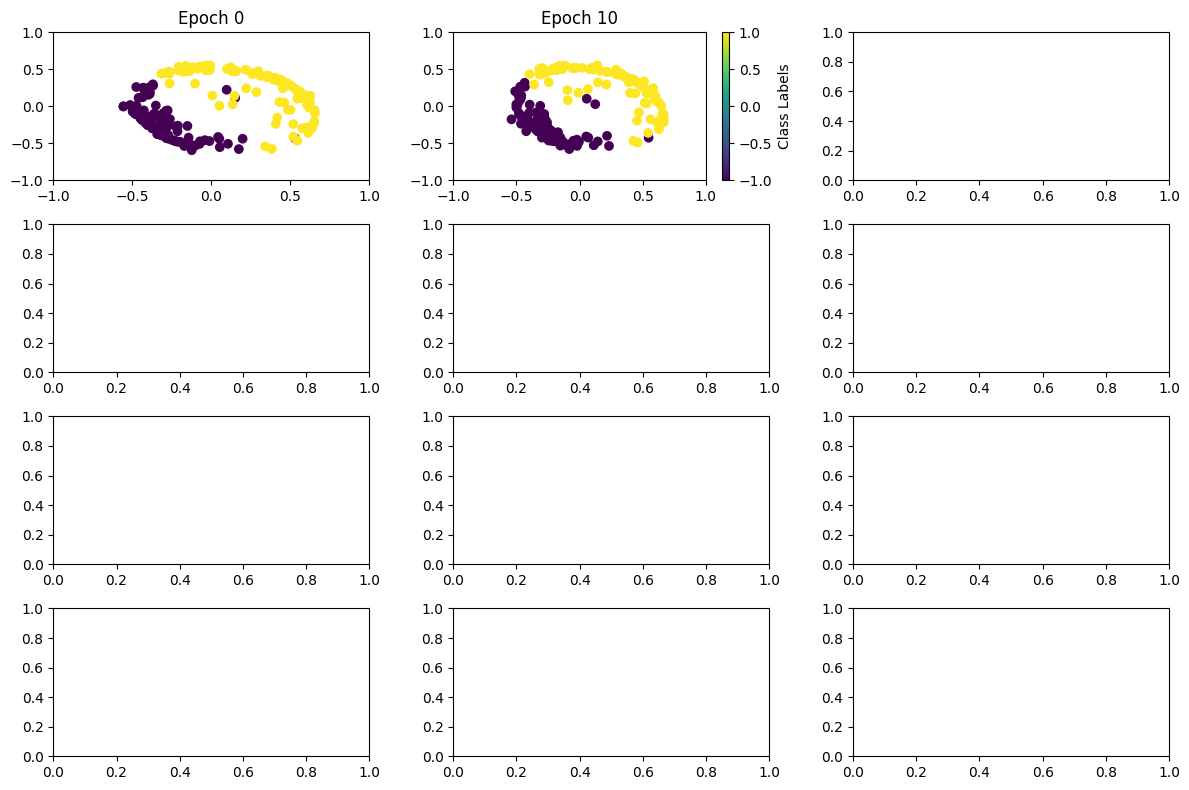

In [63]:
# Create subplot grid (2 rows, 3 columns like your example)
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

# Flatten axes array for easy iteration
axs = axs.ravel()

# Plot each kernel matrix in its subplot
for ax, (epoch, K) in zip(axs, kernel_X.items()):
    sc = plot_kernel(K, Y, ax)  # Using your function directly
    ax.set_title(f'Epoch {epoch}')
    
    # Add colorbar to the last subplot
    if epoch == list(kernel_X.keys())[-1]:
        fig.colorbar(sc, ax=ax, label='Class Labels')

plt.tight_layout()
plt.show()

Converged at iteration 3
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


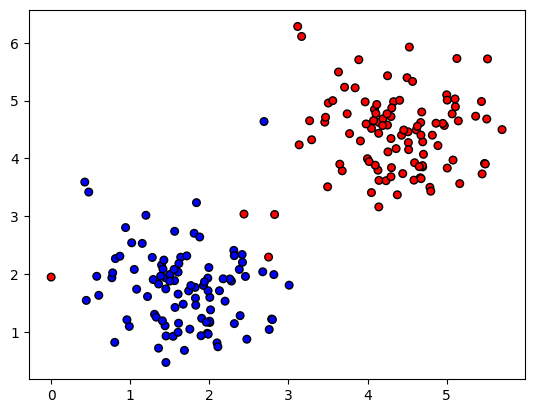

In [64]:
from kernel_KMean import KernelKMeans




trained_kernel = lambda x1, x2: qkernel.kernel_circuit(x1, x2, t_params)[0]
km = KernelKMeans(n_clusters=2, max_iter=100, random_state=0, verbose=1, kernel=trained_kernel)
    
result = km.fit(X_normalize).labels_
print(result)

cmap = ListedColormap(['#FF0000', '#0000FF'])  # Red for cluster 1, Blue for cluster 2

plt.scatter(X_normalize[:, 0], X_normalize[:, 1], c=result, cmap=cmap, s=30, edgecolor='k')

In [13]:
# 1. Instantiate QKernel 
qkernel = QKernel(
    num_wires=2,
    ansatz = Ansatz2,
    num_layers=2,                
    device_name="qiskit.aer",  
    shots=None                    
)

/Users/skande/Intership/.venv/lib/python3.11/site-packages/pennylane_qiskit/qiskit_device_legacy.py:132: UserWarning: The analytic calculation of expectations, variances and probabilities is only supported on statevector backends, not on the aer_simulator. Such statistics obtained from this device are estimates based on samples.
  warnings.warn(self.analytic_warning_message.format(backend), UserWarning)


In [21]:
# 1. Instantiate QKernel 
qkernel = QKernel(
    num_wires=2,
    ansatz = Ansatz2,
    num_layers=6,                
    device_name="default.qubit",  
    shots=None                    
)

# 2. Train the kernel
# 2. Train the kernel
t_params, loss, kernel_X = train_kernel(
    X=X_labeled_normalized,
    Y=Y_labeled,
    data = X_normalize,
    qkernel=qkernel,
    steps=20,
    lr=0.01,
    verbose=True
)

NameError: name 'X_labeled_normalized' is not defined

In [24]:
print(X[0])
print(X[1])

[2.49671415 0.58462926]
[1.8617357  1.57935468]


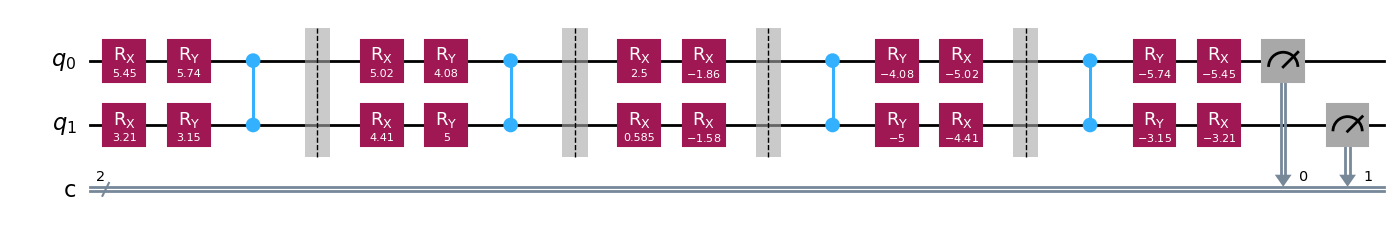

In [14]:
qkernel.visualize(X[0], X[1])

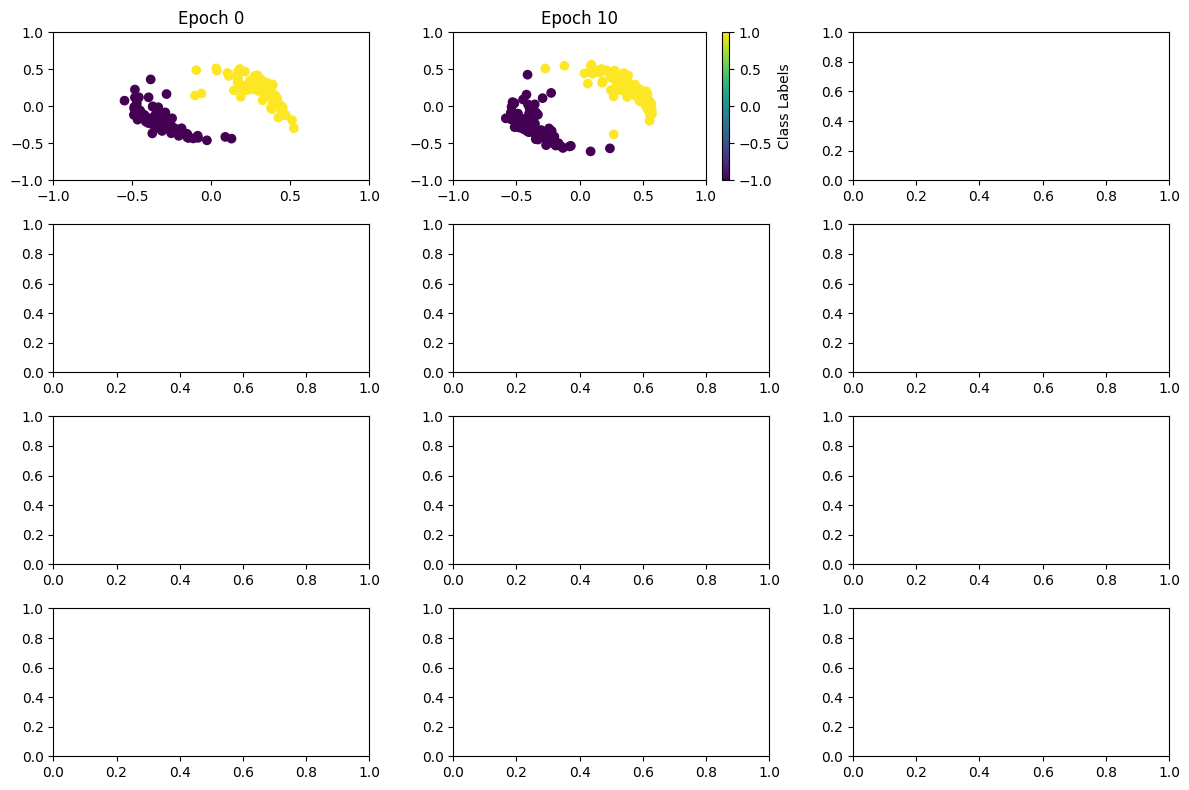

In [107]:
# Create subplot grid (2 rows, 3 columns like your example)
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

# Flatten axes array for easy iteration
axs = axs.ravel()

# Plot each kernel matrix in its subplot
for ax, (epoch, K) in zip(axs, kernel_X.items()):
    sc = plot_kernel(K, Y, ax)  # Using your function directly
    ax.set_title(f'Epoch {epoch}')
    
    # Add colorbar to the last subplot
    if epoch == list(kernel_X.keys())[-1]:
        fig.colorbar(sc, ax=ax, label='Class Labels')

plt.tight_layout()
plt.show()

Converged at iteration 2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


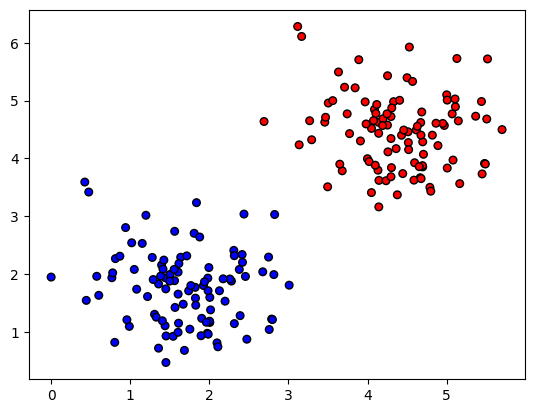

In [108]:
from kernel_KMean import KernelKMeans




trained_kernel = lambda x1, x2: qkernel.kernel_circuit(x1, x2, t_params)[0]
km = KernelKMeans(n_clusters=2, max_iter=100, random_state=0, verbose=1, kernel=trained_kernel)
    
result = km.fit(X_normalize).labels_
print(result)

cmap = ListedColormap(['#FF0000', '#0000FF'])  # Red for cluster 1, Blue for cluster 2

plt.scatter(X_normalize[:, 0], X_normalize[:, 1], c=result, cmap=cmap, s=30, edgecolor='k')

In [109]:
from sklearn.cluster import (
    SpectralClustering, 
    KMeans
)

# Clustering using the kernel
clustering_K = SpectralClustering(
    n_clusters=2,
    affinity='precomputed',
    #kernel_params = params
)

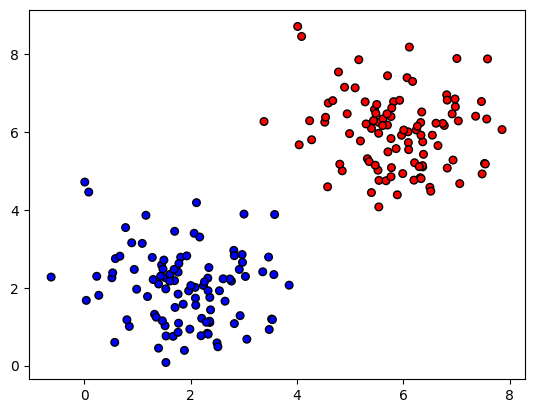

In [110]:
labels_K = clustering_K.fit_predict(kernel_X[10])
cmap = ListedColormap(['#FF0000', '#0000FF'])  # Red for cluster 1, Blue for cluster 2

plt.scatter(X[:, 0], X[:, 1], c=result, cmap=cmap, s=30, edgecolor='k')